## **WHY we need to Optimize**

Go to the last section of Evaluation and you will see that when performing evaluation on both the training and testing data.

The accuracy on training data is very high.

The accuracy on testing data is low as compared to training data.

**Thus this is the sign of OverFitting.**

## **How can we Solve this**



1.   **Adding More Data:** This we cannot do because we are already using complete data. ❌

2.   **Reducing the Complexity of NN Architecture.** We cannot do that because we are already using simple architecture. ❌

3. **Regularization:** In this we add a Penalty term in loss function. So model tries to minimize both which reduce the overfitting. L2 regularization is used mostly in Deep Learning. ✅

4. **Dropouts:** Randomly turn of some neurons during forward pass. While training some neurons are turned off randomly. ✅

5. **Data Augmentation:** Modify the data such as tranform, flip, invert, etcc. But this works good with CNNs so  we are not going to use this. ❌

6. **Batch Normalization:** Normalize the batch of the data to make mean=0 and std=1. ✅

7. **Early Stopping:** When we see that after certain epochs the loss is not reducing or else increasing then we just stop before completing all epochs.


**So we will use**

- Drop outs
- Regularization
- Batch Normalization

## **DropOut**

1. Applied to the hidden layers.

2. Applied after the ReLU **activation function.**

3. Randomly turns off **p% neurons** in the hidden layer during each forward pass.

4. This has a regularization effect.

5. During evaluation dropout is not used.

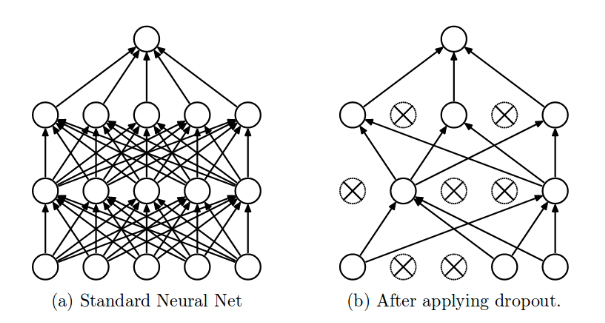

## **Batch Normalization**

This improves the Training Instability. The problem of **internal covariate shifts**.

Because output of one layer acts as input to other thus they are dependent on the previous input.

Because the weights are getting changes again and again there distribution is also changed this makes training instable.

Thus we simply normalize the mini batches of data set to be in a standard range.

- **Applied to Hidden Layers:** Typically applied to the hidden layers of a neural network, but not to the output layer.

- **Applied After Linear Layers and Before Activation Functions:** Normalizes the output of the preceding layer (e.g., after nn.Linear) and is usually followed by an activation function (e.g., ReLU).

- **Normalizes Activations:** Computes the mean and variance of the activations within a mini-batch and uses these statistics to normalize the activations.

- **Includes Learnable Parameters:**
Introduces two learnable parameters, gamma (scaling) and beta (shifting),
which allow the network to adjust the normalized outputs.

- **Improves Training Stability:**
Reduces internal covariate shift, stabilizing the training process and allowing
the use of higher learning rates.

- **Regularization Effect:**
Introduces some regularization because the statistics are computed over a
mini-batch, adding noise to the training process.

- **Consistent During Evaluation:**
During evaluation, BatchNorm uses the running mean and variance
accumulated during training, rather than recomputing them from the minibatch.

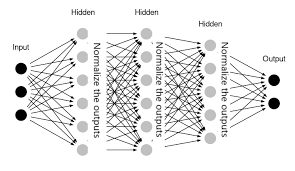

## **L2 Regularization**

- **Applied to Model Weights:** Regularization is applied to the weights of the model **(not on bias)** to penalize large values and
encourage smaller, more generalizable weights.

- **Introduced via Loss Function or Optimizer:** Adds a penalty term **λ∑wi2** to the loss function in L2 regularization.
In weight decay, directly modifies the gradient update rule to include λwi, effectively shrinking weights during training.

- **Penalizes Large Weights:**
Encourages the network to distribute learning across multiple parameters, avoiding reliance on a few large weights.

- **Reduces Overfitting:**
Helps the model generalize better to unseen data by discouraging overly complex
representations.

- **Controlled by a Hyperparameter:**
A regularization coefficient (λ, often set via weight_decay in optimizers) controls the strength of the penalty. Larger values lead to stronger regularization.

- **No Effect on Bias Terms:**
Regularization is typically applied only to weights, not biases, as biases don't directly affect model complexity.

- **Active During Training:**
Regularization affects weight updates only during training. It does not explicitly influence the model during inference.

The most easiest way to apply regularization is to implement it through weight decays.

**In optimization step during gradient descent directly add the loss to the weight.**

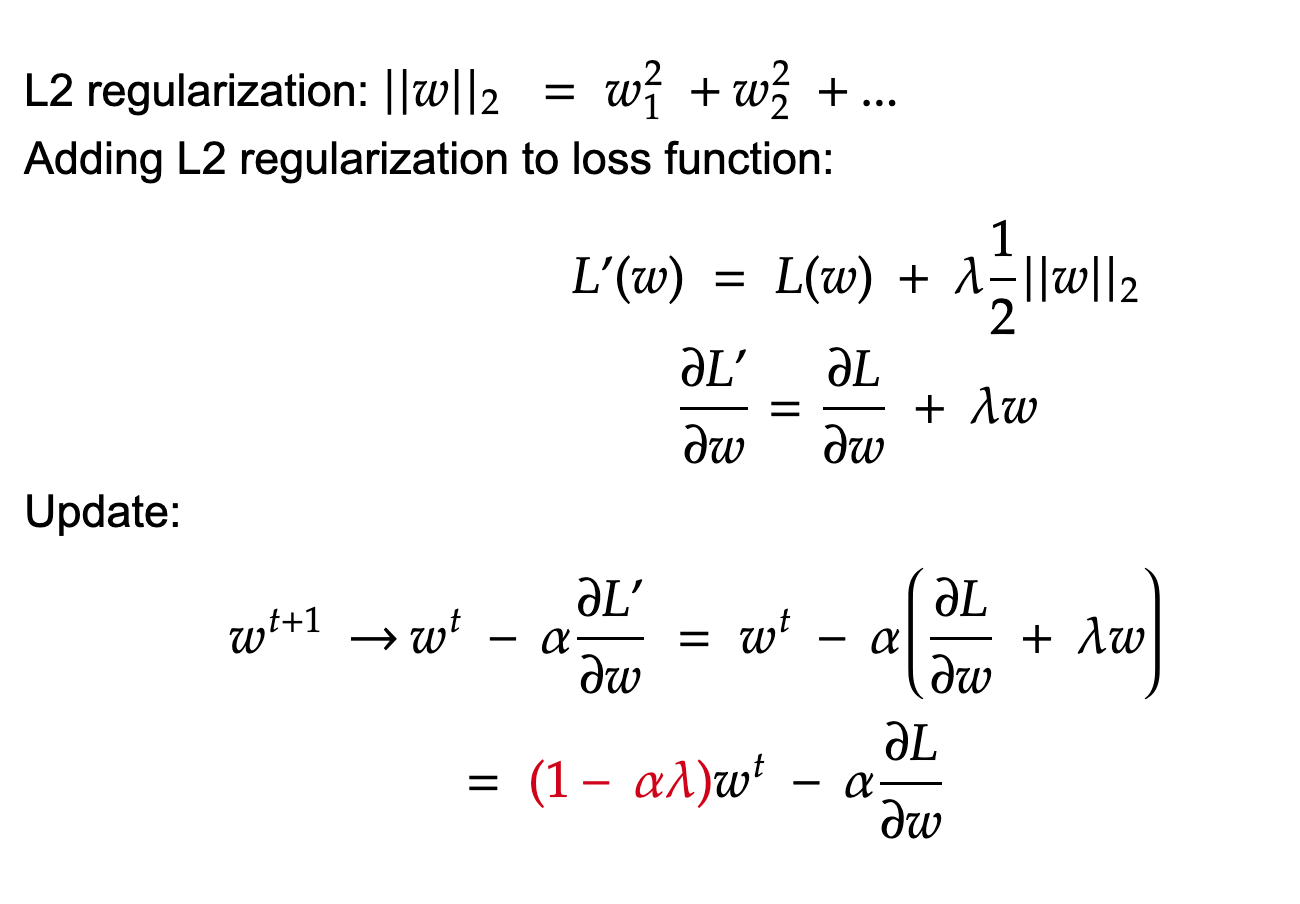

In [45]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [46]:
# Set a manual seed so that anyone running this notebook will have same result
torch.manual_seed(42)

In [47]:
"""
Always check the availability of the GPU
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

print(f"Using the {device}")


Using the cuda


In [48]:
# Read data

df = pd.read_csv("/content/fashion-mnist_train.csv")

df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df.shape

(60000, 785)

So we have 784 features.

One Label

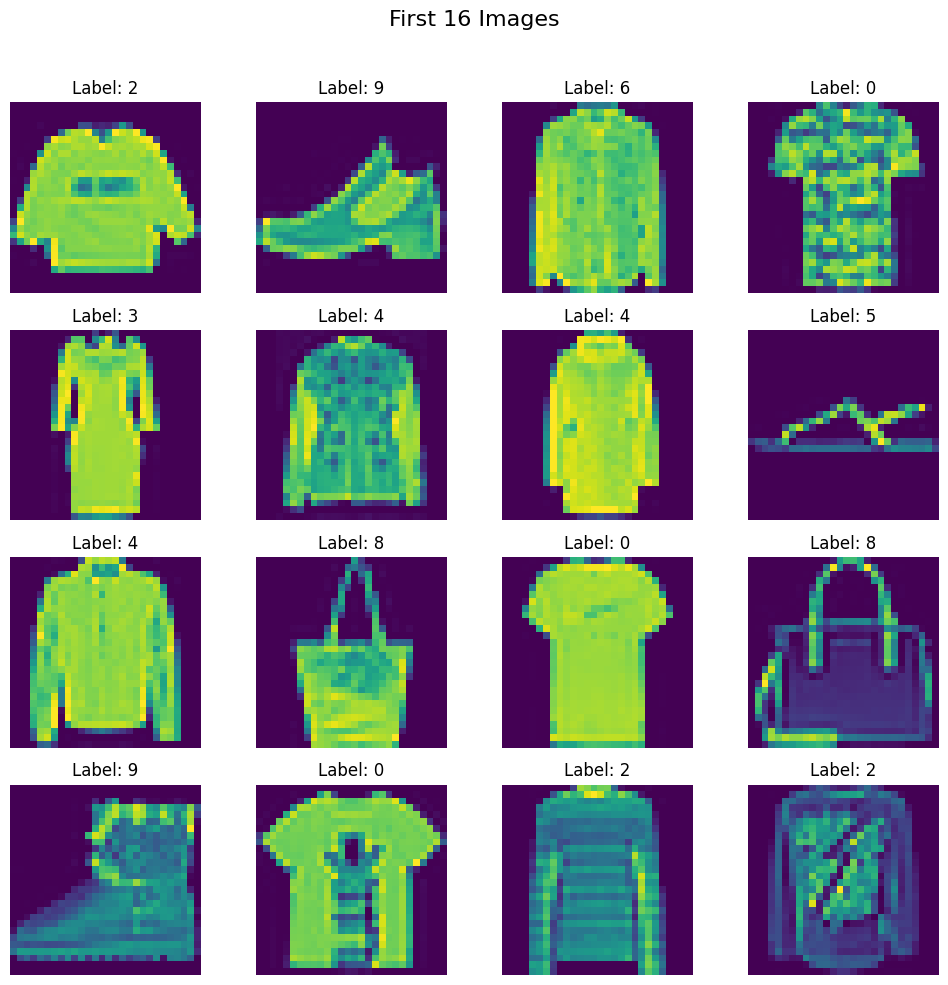

In [50]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [51]:
df['label'].nunique()

10

In [52]:
df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

So this is a Multiclass Classification Problem we have 10 different Classess.

In [53]:
# x = df.iloc[:,1:]
x = df.iloc[:,1:].values

In [54]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
x.shape

(60000, 784)

In [56]:
# Only label col
y = df.iloc[:,0].values

In [57]:
y

array([2, 9, 6, ..., 8, 8, 7])

In [58]:
y.shape

(60000,)

In [59]:
# Perform the splitting on Data
x_train, x_test , y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [60]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [61]:
x_test

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 211, 102,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [62]:
y_train

array([5, 7, 8, ..., 9, 4, 0])

In [63]:
y_test

array([7, 8, 8, ..., 9, 5, 5])

Now we can see that Most of the values in our data is 0 but some places have higher values because they are representating pixel values so we need to Normalize/Scale this between 0 to 1. We can simply do this by dividing the data with 255 Because we have 256 pixels in an image

In [64]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [65]:
x_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

## Dataset Class

In [66]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):
    """
    This thing we need to remember that Pytorch wants features as Float
    and labels as Long.
    So we are converting this here only.
    """
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
     return self.features[index], self.labels[index]

In [67]:
# train dataset object

train_dataset = CustomDataset(x_train, y_train)

In [68]:
train_dataset

In [69]:
len(train_dataset)

48000

In [70]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2275,
         0.5333, 0.0000, 0.0

In [71]:
# Test Dataset

test_dataset = CustomDataset(x_test, y_test)

In [72]:
test_dataset

In [73]:
len(test_dataset)

12000

**DATA LOADER for Batches**

In [74]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

# Because while prediction we dont need shuffling
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [75]:
# total batches
len(train_loader)

1500

## **NEURAL Network**

Keep This in Mind For Achitecture

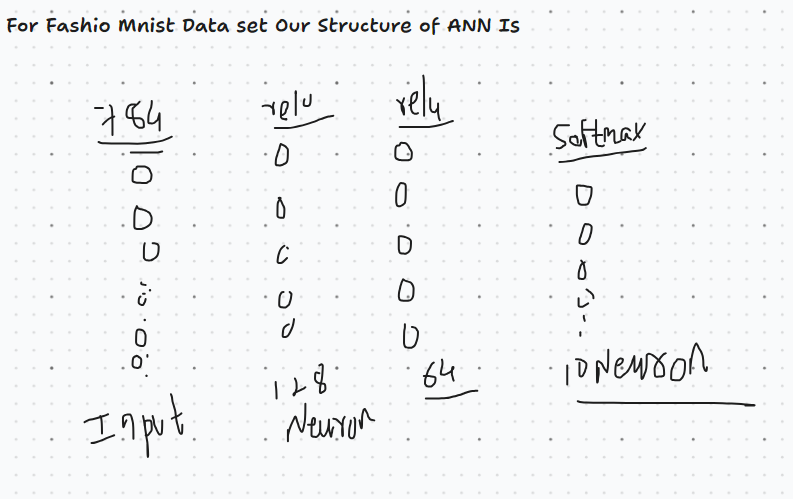

In [76]:
class MyNetwork(nn.Module):

  # constructor
  def __init__(self, num_features):
    super().__init__()
    # Create Architecture
    self.model = nn.Sequential(
        nn.Linear(num_features,128),
        # Apply batch norm to hidden layer befor activation function
        nn.BatchNorm1d(128), #tell activation in current layer
        nn.ReLU(),

        # Apply dropout after activation to hidden layer
        nn.Dropout(p=0.3),
        nn.Linear(128,64), #hidden layer 1
        # Apply batch norm to hidden layer befor activation function
        nn.BatchNorm1d(64), #tell activation in current layer
        nn.ReLU(),

        nn.Dropout(p=0.3),
        nn.Linear(64,10), #hidden layer 2
    )

  # forward
  def forward(self,x):
    # Just pass the number of featurs recievd to model
    return self.model(x)

## **Training PipeLine**

**Define Params**

In [78]:
# Parameters

epochs = 100
learning_rate = 0.01

In [79]:
# Model
# Here we are only passing the number of features not actual data
model = MyNetwork(x_train.shape[1])

In [80]:
"""
Move the Model to GPU
"""

model.to(device)

MyNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [81]:
# Loss function
criteria = nn.CrossEntropyLoss()

In [82]:
# Optimizer
# Pass weights and Bias and learning Rate

# For l2 regularization simply add the loss to the gradient descent.
# For this most easiest way is to do it throught weight decay.
# Just add loss to gradients
# Pass lambda value to weight decay => 1e-4 means 10^-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

**Actual training**

In [83]:
for epoch in range(epochs):

  # just to check all batches loss
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:

    """
    Move data to gpu
    """
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)


    # forward pass
    outputs = model.forward(batch_features)

    # calculate loss
    loss = criteria(outputs, batch_labels)

    # clear gradient
    optimizer.zero_grad()

    # backprop(calculate gradient)
    loss.backward()

    # update weigths and bias
    optimizer.step()

    # Add to epoch loss just for checking loss of each epoch
    total_epoch_loss += loss

  # Average Loss
  avg_loss = total_epoch_loss/len(train_loader)

  print(f"Epoch:{epoch +1}, Loss:{avg_loss}")
  print("-"*30)


Epoch:1, Loss:0.8244664669036865
------------------------------
Epoch:2, Loss:0.5676986575126648
------------------------------
Epoch:3, Loss:0.5128670334815979
------------------------------
Epoch:4, Loss:0.4831341803073883
------------------------------
Epoch:5, Loss:0.4625924825668335
------------------------------
Epoch:6, Loss:0.44867420196533203
------------------------------
Epoch:7, Loss:0.43171268701553345
------------------------------
Epoch:8, Loss:0.4257756173610687
------------------------------
Epoch:9, Loss:0.40935376286506653
------------------------------
Epoch:10, Loss:0.4031327962875366
------------------------------
Epoch:11, Loss:0.3986796736717224
------------------------------
Epoch:12, Loss:0.38983434438705444
------------------------------
Epoch:13, Loss:0.3811650276184082
------------------------------
Epoch:14, Loss:0.37415367364883423
------------------------------
Epoch:15, Loss:0.3708195686340332
------------------------------
Epoch:16, Loss:0.363200634717

## **Evaluation**

First we need to set the Model to Evaluation mode.

Why we need to do so?? Why explicitly call the model to turn on evaluation mode.

Becasue in Neural Network Some features Behave different while Training and behave differently while evaluation.

**Examples:**

- Drop Layers (They Behave different while training and when testing all neurons are available).

- Batch Normalization. While training we calculate mean and std by seeing the data.

Thus we need to tell the model That we are using it for evaluation.

In [84]:
# Set to Evaluation Mode

model.eval()

MyNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

**Evaluation on Testing Data**

In [85]:
# Variables for evaluation
total = 0
correct = 0


with torch.no_grad():

  # Since our testing data is also in batches.

  for batch_features, batch_labels in test_loader:

      """
      Move data to gpu
      """
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)


      # predict on each image
      outputs = model.forward(batch_features)

      # check if it is correct or not
      # See Below Explaination
      # Row wise we need to check for each outputs max value
      # This will return value and index
      idx, v = torch.max(outputs, 1)

      # update total (Add rows)
      total += batch_labels.shape[0]

      # Correct (where predicted is same as batch_label)

      correct = correct + (v == batch_labels).sum()

accuracy = (correct/total)

print(f"Accuracy:{accuracy}")

Accuracy:0.8928333520889282


In [86]:
len(test_loader)

375

**Evaluation on Training Data**

In [87]:
# Variables for evaluation
total = 0
correct = 0


with torch.no_grad():

  # Since our testing data is also in batches.

  for batch_features, batch_labels in train_loader:

      """
      Move data to gpu
      """
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)


      # predict on each image
      outputs = model.forward(batch_features)

      # check if it is correct or not
      # See Below Explaination
      # Row wise we need to check for each outputs max value
      # This will return value and index
      idx, v = torch.max(outputs, 1)

      # update total (Add rows)
      total += batch_labels.shape[0]

      # Correct (where predicted is same as batch_label)

      correct = correct + (v == batch_labels).sum()

accuracy = (correct/total)

print(f"Accuracy:{accuracy}")

Accuracy:0.957937479019165


In [44]:
len(train_loader)

1500

**Before Optimization**

The Test Accuracy is : `0.8814166784286499`


The Training Accuracy is : `0.9673333168029785`

**This Simply means our model is Overfitted. Because Good Results on Training Data but less result on Testing Data.**

**After Optimization**

The Test Accuracy is : `0.8928333520889282`


The Training Accuracy is : `0.957937479019165`

**Now our Difference between both is comparatively lower than before**